In [2]:
from google.colab import drive
import os
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!sudo apt install tesseract-ocr-ind
!pip install pytesseract
!pip install protobuf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-ind tesseract-ocr-osd
0 upgraded, 4 newly installed, 0 to remove and 45 not upgraded.
Need to get 5,353 kB of archives.
After this operation, 16.8 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-eng all 1:4.00~git30-7274cfa-1.1 [1,591 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-osd all 1:4.00~git30-7274cfa-1.1 [2,990 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr amd64 4.1.1-2.1build1 [236 kB]
Get:4 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-ind all 1:4.00~git30-7274cfa-1.1 [537 kB]
Fetched 5,353 kB in 1s (4,295 kB/s)
debconf: unable to ini

In [4]:
import cv2
import json
import re
import numpy as np
import pandas as pd
import pytesseract
import matplotlib.pyplot as plt
from PIL import Image

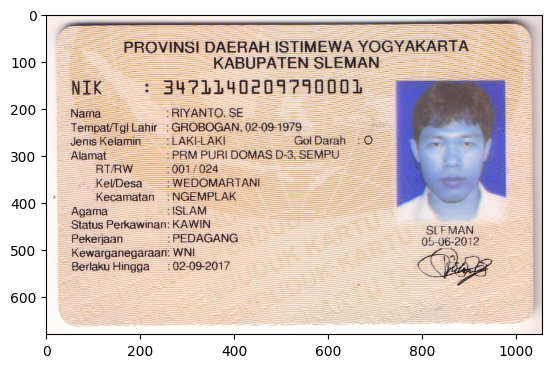

In [5]:
FILE_PATH = '/content/drive/MyDrive/ocrktp/dataset'
filePath= os.path.join(FILE_PATH, 'ktp.png')

img = cv2.imread(filePath)
plt.imshow(img)

In [6]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
th, threshed = cv2.threshold(gray, 127, 255, cv2.THRESH_TRUNC)

result = pytesseract.image_to_string((threshed), lang="ind")

for word in result.split("\n"):
  if "”—" in word:
    word = word.replace("”—", ":")
  if "NIK" in word:
    nik_char = word.split()
    if "?" in word:
      word = word.replace("?", "7")
    if "D" in word:
      word = word.replace("D", "0")

  print(word)

em

PROVINSI DAERAH ISTIMEWA YOGYAKARTA
KABUPATEN SLEMAN

 

NIK : 34711140209790001

Nama :RIYANTO. SE

Tempat/Tgl Lahir : GROBOGAN. 02-09-1979

Jenis Kelamin : LAKI-LAKI Gol Darah : 0

Alamat PRM PURI DOMAS D-3. SEMPU
RTRW 1001 1024

Kel/Desa : WEDOMARTANI!
Kecamatan : NGEMPLAK

Agama "ISLAM
Status Bean KAWIN SLEMAN
Pekerjaan : PEDAGANG 05-06-2012

Kewarganegaraan: WNI HI —
Berlaku Hingga :02-09-2017 NIA

   
 

 



In [7]:
class KTPInformation(object):
    def __init__(self):
        self.nik = ""
        self.nama = ""
        self.tempat_lahir = ""
        self.tanggal_lahir = ""
        self.jenis_kelamin = ""
        self.golongan_darah = ""
        self.alamat = ""
        self.rt = ""
        self.rw = ""
        self.kelurahan_atau_desa = ""
        self.kecamatan = ""
        self.agama = ""
        self.status_perkawinan = ""
        self.pekerjaan = ""
        self.kewarganegaraan = ""
        berlaku_hingga = "SEUMUR HIDUP"


In [8]:
class KTPOCR(object):
    def __init__(self, image):
        self.image = cv2.imread(image)
        self.gray = cv2.cvtColor(self.image, cv2.COLOR_BGR2GRAY)
        self.th, self.threshed = cv2.threshold(self.gray, 127, 255, cv2.THRESH_TRUNC)
        self.result = KTPInformation()
        self.master_process()

    def process(self, image):
        raw_extracted_text = pytesseract.image_to_string((self.threshed), lang="ind")
        return raw_extracted_text

    def word_to_number_converter(self, word):
        word_dict = {
            "L": "1",
            "l": "1",
            "O": "0",
            "o": "0",
            "?": "7",
            "A": "4",
            "Z": "2",
            "z": "2",
            "S": "5",
            "s": "5",
            "b": "6",
            "B": "8",
            "G": "6"
        }
        res = ""
        for letter in word:
            if letter in word_dict:
                res += word_dict[letter]
            else:
                res += letter
        return res

    def extract(self, extracted_result):
        #print(extracted_result.replace('\n', ' -- '))
        for word in extracted_result.split("\n"):
            word = self.pun_rem(word)

            if "NIK" in word:
              word = word.split(':')
              self.result.nik = self.word_to_number_converter(word[-1].replace(" ", ""))
              continue

            if "Nama" in word:
              word = word.split(':')
              self.result.nama = word[-1]
              continue

            if "Lahir" in word:
                word = word.split(':')
                date_match = re.search("([0-9]{2}\-[0-9]{2}\-[0-9]{4})", word[-1])
                if date_match:
                    self.result.tanggal_lahir = date_match[0]
                    self.result.tempat_lahir = word[-1].replace(self.result.tanggal_lahir, '')
                continue

            if "Gol" in word:
                word = word.split(':')
                if len(word) > 1:
                    gender_match = re.search("(LAKI-LAKI|LAKI|PEREMPUAN|LELAKI|PEREMPUAN)", word[1])
                    if gender_match:
                        self.result.jenis_kelamin = gender_match[0]
                continue

            if "Alamat" in word:
              self.result.alamat = re.sub(r'^\W*\w+\W*', '', word)
              continue

            if "RW" in word:
                word = re.sub(r'^\W*\w+\W*', '', word)
                if " " in word:
                    a = word.split(" ")
                elif "/" in word:
                    a = word.split("/")
                else:
                    a = [word[:3], word[3:]]

                self.result.rt = a[0][-3:]
                self.result.rw = a[1][-3:]
                continue

            if "kel" in word:
              word = re.sub(r'^\W*\w+\W*', '', word)
              self.result.kecamatan = word
              continue

            if "Agama" in word:
              self.result.agama = re.search("(ISLAM|KRISTEN|KATOLIK|HINDU|BUDDHA|KONG HU CU)", word)[0]
              continue

            if "Status" in word:
              self.result.status_perkawinan = re.search("(KAWIN|BELUM KAWIN|DUDA CERAI|DUDA MATI|JANDA CERAI|JANDA MATI)", word)[0]
              continue

            if "Pekerjaan" in word:
              word = re.sub(r'^\W*\w+\W*', '', word)
              word = word.split(" ")
              self.result.pekerjaan = word[0]
              continue

            if "Kewarganegaraan" in word:
              self.result.kewarganegaraan = re.search("(WNI|WNA)", word)[0]
              continue

    def pun_rem(self,text):
      punctuations = '''!()[]{}'"\<>?@#$%^&*_~'''
      no_punct = ''

      for char in text:
        if char not in punctuations:
          no_punct = no_punct + char

      return no_punct

    def master_process(self):
        raw_text = self.process(self.image)
        self.extract(raw_text)

    def to_json(self):
        return json.dumps(self.result.__dict__, indent=4)


In [9]:
images = KTPOCR(filePath)
print(images.to_json());

{
    "nik": "34711140209790001",
    "nama": "RIYANTO. SE",
    "tempat_lahir": " GROBOGAN. ",
    "tanggal_lahir": "02-09-1979",
    "jenis_kelamin": "LAKI-LAKI",
    "golongan_darah": "",
    "alamat": "PRM PURI DOMAS D-3. SEMPU",
    "rt": "001",
    "rw": "024",
    "kelurahan_atau_desa": "",
    "kecamatan": "",
    "agama": "ISLAM",
    "status_perkawinan": "KAWIN",
    "pekerjaan": "PEDAGANG",
    "kewarganegaraan": "WNI"
}
